In [6]:
# This notebook illustrates handling the September 2024 Demo of the 18-month epi evaluation scenario 2 question 9

# Import funman related code
import os
from funman import MODE_ODEINT, MODE_SMT, Interval, LinearConstraint
from funman.model.petrinet import GeneratedPetriNetModel

import json
import pandas as pd
import logging
import matplotlib.pyplot as plt
from helpers import run, get_model, setup_common, get_request, report
from funman import to_sympy
from funman.model.generated_models.petrinet import Initial
from typing import Dict
from funman import GeneratedPetriNetModel
from difflib import SequenceMatcher
from functools import reduce

RESOURCES = "../../resources"
SAVED_RESULTS_DIR = "./out"

EXAMPLE_DIR = os.path.join(RESOURCES, "amr", "petrinet","monthly-demo", "2024-09")
REQUEST_PATH = os.path.join(
    EXAMPLE_DIR, "sir_request1.json")

models = {
    "sir": os.path.join(
    EXAMPLE_DIR, "sir.json"),
}

requests = {
    "sir": REQUEST_PATH,
    "sir_stratified": os.path.join(EXAMPLE_DIR, "sir_stratified_request.json"),
    "sir_bounded": os.path.join(EXAMPLE_DIR, "sir_bounded_request.json")
}

request_params = {}
request_results = {}

In [7]:
# Constants for the scenario

MAX_TIME=100
STEP_SIZE=10
timepoints = list(range(0, MAX_TIME+STEP_SIZE, STEP_SIZE))

1 points
        beta  gamma
sir  0.00026    0.1


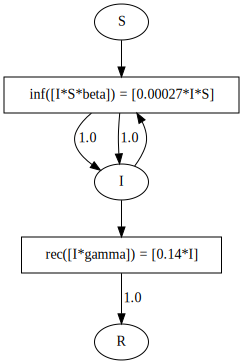

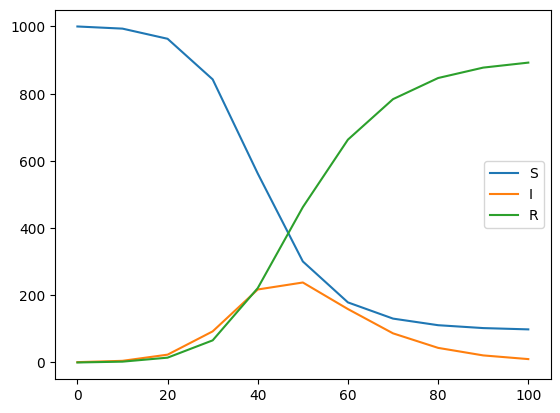

In [8]:
# 1) Process Base Model
model_str = "sir"
(base_model, request) = get_model(models[model_str])

funman_request = get_request(requests[model_str])
setup_common(funman_request, timepoints, debug=True, mode=MODE_ODEINT, synthesize=False,dreal_precision=1)
results = run(funman_request, model_str, models)
report(results, model_str, base_model._state_var_names() + base_model._observable_names(), request_results, request_params)
base_model.to_dot()

1 points
                   beta  gamma    beta_1    beta_2
sir             0.00026    0.1       NaN       NaN
sir_stratified      NaN    0.1  0.000266  0.000374


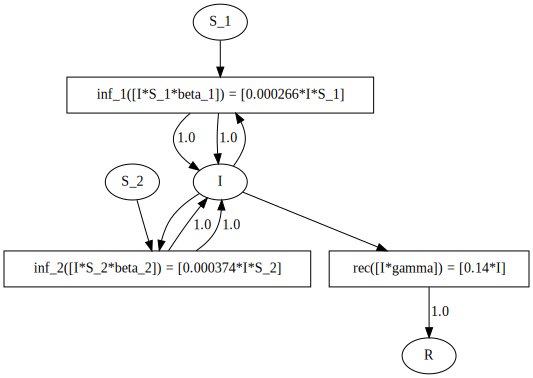

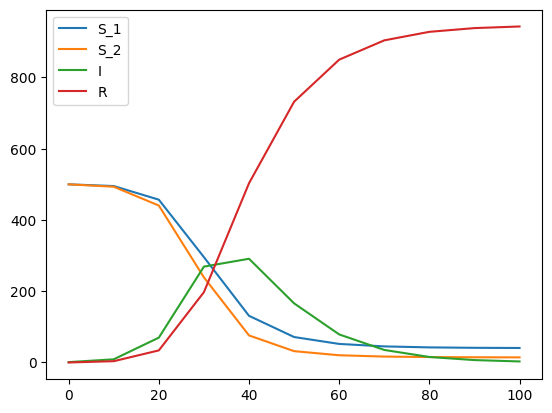

In [9]:
# Stratify the Base model with vaccination status

from typing import Dict, List, Optional
from funman.model.generated_models.petrinet import Model1, Parameter, Rate, State,Transition, Properties, Model, Semantics, OdeSemantics, Initial
from funman.model.petrinet import GeneratedPetriNetModel, PetrinetModel
from sympy import Symbol




def stratify(
    self: PetrinetModel, 
    state_var: str, 
    strata: List[str], 
    strata_parameters:Optional[List[str]]=None, 
    strata_transitions=[], 
    self_strata_transition=False
    ):
    """
    Generate a new model that stratifies self.  The 'state_var' will be replaced by one copy 
    per entry in the 'strata' list.  The 'strata_parameters', if specified, will be replaced 
    by a fresh copy that corresponds to each element of the strata list in each transition 
    involving the 'state_var'.  The 'strata_transitions' list includes all transitions 
    involving 'state_var' to allow transitioning between the elements of 'strata', if 
    possible (e.g., if 'state_var' is both and input and an output of the transition).  The 
    'self_strata_transition' flag adds transitions between all pairs of entries in 'strata'.
    When either 'strata_transitions' or 'self_strata_transition' are specified, the rates 
    will incorporate a new parameter that defines the probability of transitioning between
    elements of the strata list.  The transition probability parameters are assigned a value
    of 1/len('strata'), treating the transitions as a uniform probability distribution.

    Parameters
    ----------
    self : PetrinetModel
        _description_
    state_var : str
        _description_
    strata : List[str]
        _description_
    strata_parameters : Optional[List[str]], optional
        _description_, by default None
    strata_transitions : list, optional
        _description_, by default []
    self_strata_transition : bool, optional
        _description_, by default False

    Returns
    -------
    _type_
        _description_
    """    
    
    # get state variable
    state_vars: List[State] = [s for s in self._state_vars() if self._state_var_name(s) == state_var]
    assert len(state_vars) == 1, "Found more than one State variable for {state_var}"
    original_var = state_vars[0]
    new_vars = [State(id=f"{original_var.id}_{level}", name=f"{original_var.name}_{level}", description=f"{original_var.description} Stratified wrt. {level}", grounding=original_var.grounding, units=original_var.units) for level in strata]
    unchanged_vars = [ s.id for s in self._state_vars() if s != original_var]
    
    # get new transitions
    transitions: Dict[str, Transition] = {t.id: t for t in self._transitions() if original_var.id in t.input or original_var.id in t.output}
    other_transitions = {t.id: t for t in self._transitions() if t.id not in transitions}
    
    src_only_transitions: Dict[str, Transition]  = {t_id: t for t_id, t in transitions.items() if original_var.id in t.input and original_var.id not in t.output}
    dest_only_transitions: Dict[str, Transition]  = {t_id: t for t_id, t in transitions.items() if original_var.id not in t.input and original_var.id in t.output}
    src_and_dest_transitions: Dict[str, Transition] = {t_id: t for t_id, t in transitions.items() if original_var.id in t.input and original_var.id in t.output }
    
    # Replicate transitions where original_var is in source
    new_src_transitions = [
        Transition(id=f"{t.id}_{level}", 
                   input=[(s if s!= original_var.id else f"{s}_{level}") for s in t.input], 
                   output=t.output, 
                   grounding=t.grounding, 
                   properties=Properties(name=f"{t.properties.name}_{level}", description=(f"{t.properties.description} Stratified wrt. {level}" if t.properties.description else t.properties.description))) 
        for t_id, t in src_only_transitions.items()
        for level in strata
        ]
    
    # Replicate transitions where original_var is in destination
    new_dest_transitions = [
        Transition(id=f"{t.id}_{level}", 
                   input=t.input, 
                   output=[(s if s!= original_var.id else f"{s}_{level}") for s in t.output], 
                   grounding=t.grounding, 
                   properties=Properties(name=f"{t.properties.name}_{level}", description=(f"{t.properties.description} Stratified wrt. {level}" if t.properties.description else t.properties.description))) 
        for t_id,t in dest_only_transitions.items()
        for level in strata
        ]
    
    # Replicate transitions where original_var is in source and destination
    new_src_dest_transitions = [
        Transition(id=f"{t.id}_{level_s}_{level_t}", 
                   input=[(s if s!= original_var.id else f"{s}_{level_s}") for s in t.input], 
                   output=[(s if s!= original_var.id else f"{s}_{level_t}") for s in t.output], 
                   grounding=t.grounding, 
                   properties=Properties(name=f"{t.properties.name}_{level_s}_{level_t}", description=(f"{t.properties.description} Stratified wrt. {level_s}, {level_t}." if t.properties.description else t.properties.description))) 
        for t_id,t in src_and_dest_transitions.items()
        for level_s in strata
        for level_t in strata
        if t_id in strata_transitions or level_s == level_t
        ]
    
    new_transitions = new_src_transitions +new_dest_transitions + new_src_dest_transitions
        
    # Modify rates by substituting fresh versions of the strata_parameters
    old_rates = {t_id: self._transition_rate(t) for t_id, t in transitions.items()}
    other_rates = {r.target: r for r in self.petrinet.semantics.ode.rates if r.target in other_transitions}
    
    src_only_rates = [
            Rate(
                target=f"{t_id}_{level}", 
                expression=(reduce(lambda x, y: x.replace(y, f"{y}_{level}"), strata_parameters, str(r[0])) if strata_parameters else str(r[0])).replace(state_var, f"{state_var}_{level}")
            ) 
            for t_id,r in old_rates.items() 
            if t_id in src_only_transitions 
            for level in strata
        ]

    dest_only_rates = [
        Rate(
            target=f"{t_id}_{level}", 
            expression=(reduce(lambda x, y: x.replace(y, f"{y}_{level}"), strata_parameters, str(r[0])) if strata_parameters else str(r[0])).replace(state_var, f"{state_var}_{level}")
        )  
        for t_id,r in old_rates.items() 
        if t_id in dest_only_transitions 
        for level in strata
    ]

    src_and_dest_rates = [
            Rate(
                target=f"{t_id}_{level_s}_{level_t}", 
                expression=f"p_{state_var}_{level_s}_{level_t}*"+(reduce(lambda x, y: x.replace(y, f"{y}_{level_s}_{level_t}"), strata_parameters, str(r[0])) if strata_parameters else str(r[0])).replace(state_var, f"{state_var}_{level_s}")
            ) 
            for t_id,r in old_rates.items() 
            if t_id in src_and_dest_transitions 
            for level_s in strata 
            for level_t in strata
        ]

    new_rates = src_only_rates + dest_only_rates + src_and_dest_rates

    new_states = new_vars + [s for s in self.petrinet.model.states.root if s not in state_vars]
    
    # update with new states by splitting old state values
    original_init_value = to_sympy(next(i.expression for i in self.petrinet.semantics.ode.initials if i.target == original_var.id), {})
    
    new_initials = [i for i in self.petrinet.semantics.ode.initials if i.target in unchanged_vars] + [
        Initial(target=n.id, expression=str(original_init_value/float(len(new_vars))))
        for n in new_vars
    ]
    
    
    if strata_parameters is not None:
        original_parameter_values = {p: self._parameter_values()[p] for p in strata_parameters}
        original_parameters = {sp:next(iter([p for p in self.petrinet.semantics.ode.parameters if p.id == sp])) for sp in strata_parameters}
        unchanged_parameters = [p for p in self.petrinet.semantics.ode.parameters if p.id not in strata_parameters]
        src_only_parameters = [ 
            Parameter(id=f"{sp}_{level}", name = f"{sp}_{level}", description=f"{original_parameters[sp].description} stratified as {sp}_{level}", value=original_parameter_values[sp], distribution=original_parameters[sp].distribution, units=original_parameters[sp].units, grounding=original_parameters[sp].grounding)
            for t_id,r in old_rates.items() 
            for sp in strata_parameters
            if t_id in src_only_transitions and Symbol(sp) in old_rates[t_id][0].free_symbols 
            for level in strata

        ]

        dest_only_parameters = [
            Parameter(id=f"{sp}_{level}", name = f"{sp}_{level}", description=f"{original_parameters[sp].description} stratified as {sp}_{level}", value=original_parameter_values[sp], distribution=original_parameters[sp].distribution, units=original_parameters[sp].units, grounding=original_parameters[sp].grounding)
            for t_id,r in old_rates.items() 
            for sp in strata_parameters
            if t_id in dest_only_transitions and Symbol(sp) in old_rates[t_id][0].free_symbols 
            for level in strata
            ]

        src_and_dest_parameters = [
            Parameter(id=f"{sp}_{level_s}_{level_t}", name = f"{sp}_{level_s}_{level_t}", description=f"{original_parameters[sp].description} stratified as {sp}_{level_s}_{level_t}", value=original_parameter_values[sp], distribution=original_parameters[sp].distribution, units=original_parameters[sp].units, grounding=original_parameters[sp].grounding)
            for t_id,r in old_rates.items() 
            for sp in strata_parameters
            if t_id in src_and_dest_transitions and Symbol(sp) in old_rates[t_id][0].free_symbols 
            for level_s in strata for level_t in strata
        ]
        transition_probability_parameters = [
            Parameter(id= f"p_{state_var}_{level_s}_{level_t}", name =  f"p_{state_var}_{level_s}_{level_t}", description= f"p_{state_var}_{level_s}_{level_t}", value=str(1.0/float(len(strata))), distribution=None, units=None, grounding=None)
            for t_id,r in old_rates.items() 
            if t_id in src_and_dest_transitions
            for level_s in strata for level_t in strata
        ]
        new_parameters = unchanged_parameters + src_only_parameters + dest_only_parameters + src_and_dest_parameters + transition_probability_parameters
    else:
        new_parameters = self.petrinet.semantics.ode.parameters
    
    # FIXME update with splits
    new_observables = self.petrinet.semantics.ode.observables
    
    if self_strata_transition:
        self_strata_transitions = [
            Transition(id=f"p_{state_var}_{level_s}_{level_t}", input=[f"{state_var}_{level_s}"], output=[f"{state_var}_{level_t}"], grounding=None, properties={"name": f"p_{state_var}_{level_s}_{level_t}"}) 
            for level_s in strata 
            for level_t in strata 
            if level_s != level_t
            ]
        self_strata_rates = [
            Rate(target=f"p_{state_var}_{level_s}_{level_t}", expression=f"{state_var}_{level_s}*p_{state_var}_{level_s}_{level_t}") 
            for level_s in strata 
            for level_t in strata 
            if level_s != level_t
            ]
        self_strata_parameters = [
            Parameter(id=f"p_{state_var}_{level_s}_{level_t}", name=f"p_{state_var}_{level_s}_{level_t}", description="Transition rate parameter between {state_var} strata {level_s} and {level_t}.", value=1.0/float(len(strata))) 
            for level_s in strata 
            for level_t in strata 
            # if level_s != level_t
            ] if len(transition_probability_parameters) == 0 else []
    else:
        self_strata_transitions = []
        self_strata_rates = []
        self_strata_parameters = []    
    
    
    new_model = GeneratedPetriNetModel(
                    petrinet=Model(
                        header=self.petrinet.header,
                        properties=self.petrinet.properties,
                        model=Model1(
                          states=new_states, 
                          transitions=[*new_transitions, *other_transitions.values(), *self_strata_transitions]
                          ),
                        semantics=Semantics(
                          ode=OdeSemantics(
                              rates=[*new_rates, *other_rates.values(), *self_strata_rates], 
                              initials=new_initials, 
                              parameters=new_parameters+self_strata_parameters, 
                              observables=new_observables,
                              time=self.petrinet.semantics.ode.time), 
                          typing=self.petrinet.semantics.typing, span=self.petrinet.semantics.span),
                      metadata=self.petrinet.metadata
                      ))

    return new_model #new_rates, transitions, new_transitions # dest_only_rates #original_var, new_vars, new_transitions
    
# 2) Analyze Stratified Base Model    
    
# Stratify the base model
stratified_model = stratify(base_model, "S", ["1", "2"], strata_parameters=["beta"], strata_transitions=None, self_strata_transition=False)

# Modify the beta_1 and beta_2 parameters
parameters = stratified_model.petrinet.semantics.ode.parameters
beta_1 = next(p for p in parameters if p.id == "beta_1")
beta_2 = next(p for p in parameters if p.id == "beta_2")
beta_1_width = (beta_1.distribution.parameters["maximum"] - beta_1.distribution.parameters["minimum"]) 
beta_1.value = beta_1.distribution.parameters["minimum"] + 0.05 * beta_1_width
beta_2_width = (beta_2.distribution.parameters["maximum"] - beta_2.distribution.parameters["minimum"]) 
beta_2.value = beta_2.distribution.parameters["minimum"] + 0.95 * beta_2_width                            

# Save the stratified model
stratified_model_str = f"{model_str}_stratified"
stratified_model_path = os.path.join(EXAMPLE_DIR, stratified_model_str+".json")
models[stratified_model_str] = stratified_model_path
with open(stratified_model_path, "w") as f:
    f.write(stratified_model.petrinet.model_dump_json())


# Analyze the stratified model
stratified_request = get_request(requests[stratified_model_str])

# Modify request parameters
request_parameters = stratified_request.parameters
req_beta_1 = next(p for p in request_parameters if p.name == "beta_1")
req_beta_2 = next(p for p in request_parameters if p.name == "beta_2")
req_beta_1.interval = Interval(lb=beta_1.value, ub = beta_1.value, closed_upper_bound = True)
req_beta_2.interval = Interval(lb=beta_2.value, ub = beta_2.value, closed_upper_bound = True)

# stratified_request = FunmanWorkRequest()
setup_common(stratified_request, timepoints, debug=True, mode=MODE_ODEINT, synthesize=False,dreal_precision=1)
results = run(stratified_request, stratified_model_str, models)
report(results, stratified_model_str, stratified_model._state_var_names() + stratified_model._observable_names(), request_results, request_params)
stratified_model.to_dot()

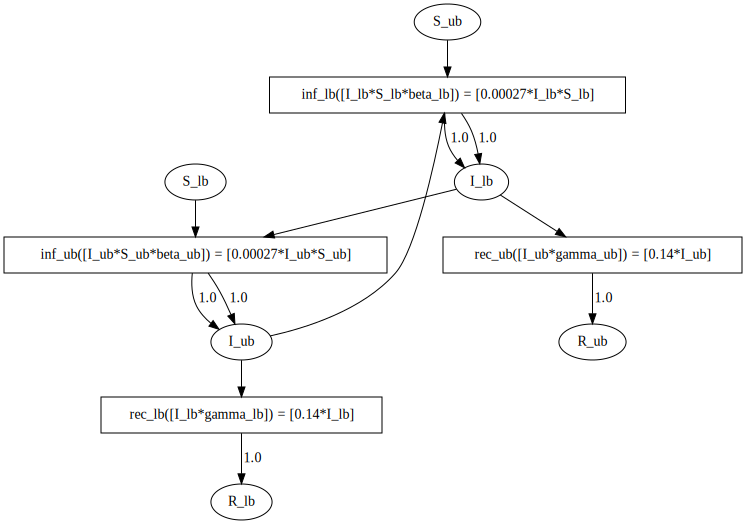

In [10]:
def formulate_bounds(self: GeneratedPetriNetModel):
    # Reformulate model into bounded version 
    # - replace each state S by S_lb and S_ub
    # - replace each transition T by T_lb and T_ub
    # - replace related parameters by their lb and ub, using abstracted values in metadata if present
    # - replace rates by transition type
    
    bounded_states = [
            State(id=f"{s.id}_lb", name=f"{s.id}_lb", 
                  description=f"{s.description} lb", 
                  grounding=s.grounding, units=s.units) 
            for s in self.petrinet.model.states
        ] + [
            State(id=f"{s.id}_ub", name=f"{s.id}_ub", 
                  description=f"{s.description} ub", 
                  grounding=s.grounding, units=s.units) 
            for s in self.petrinet.model.states
        ]
    bounded_transitions = [
        Transition(id=f"{t.id}_lb", 
                   input=[f"{s}_ub" for s in t.input], 
                   output=[f"{s}_lb"  for s in t.output], 
                   grounding=t.grounding, 
                   properties=Properties(
                       name=f"{t.id}_lb", 
                       description=(f"{t.properties.description} lb" if t.properties.description else t.properties.description))) 
        for t in self.petrinet.model.transitions
    ] + [
        Transition(id=f"{t.id}_ub", 
                   input=[f"{s}_lb" for s in t.input], 
                   output=[f"{s}_ub"  for s in t.output], 
                   grounding=t.grounding, 
                   properties=Properties(
                       name=f"{t.id}_ub", 
                       description=(f"{t.properties.description} ub" if t.properties.description else t.properties.description)))
        for t in self.petrinet.model.transitions
    ]
    
    
    def bound_expression(e, symbols, bound, metadata):
        substitution = {s: f"{s}_{bound}" for s in symbols}
        for param, bounds in metadata.items():
            substitution[param] = param.replace("agg_", f"{bound}_")
        
        f = to_sympy(e, symbols)
        f_b = f.subs(substitution)
        return f_b
    
    def lb_expression(e, symbols, metadata):
        return bound_expression(e, symbols, "lb", metadata)
    
    def ub_expression(e, symbols, metadata):
       return bound_expression(e, symbols, "ub", metadata)
    
    symbols = self._symbols()
    
    # lb transitions use rates that will:
    #   - decrease ub terms by the least amount
    #   - increase lb terms by the least amount
    # ub transitions use rates that will:
    #   - vice versa wrt. above
    
    abstraction_metadata = self.petrinet.metadata.get("abstraction", {})
    
    bounded_rates = [
        Rate(target=f"{r.target}_lb", 
             expression=str(lb_expression(r.expression, symbols, abstraction_metadata.get("parameters", {}).get(r.target, {})))) 
        for r in self.petrinet.semantics.ode.rates
    ] + [
        Rate(target=f"{r.target}_ub", 
             expression=str(ub_expression(r.expression, symbols, abstraction_metadata.get("parameters", {}).get(r.target, {})))) 
        for r in self.petrinet.semantics.ode.rates
    ]
    bounded_initials = [
        Initial(target=f"{r.target}_lb", 
             expression=r.expression,
             expression_mathml=r.expression_mathml) 
        for r in self.petrinet.semantics.ode.initials
    ] + [
        Initial(target=f"{r.target}_ub", 
             expression=r.expression,
             expression_mathml=r.expression_mathml)
        for r in self.petrinet.semantics.ode.initials
    ]
    
    abstract_bounded_parameters = {
        p: {
            p.replace("agg_", "lb_"): bounds['lb'],
            p.replace("agg_", "ub_"): bounds['ub']
        }
        for t, params in abstraction_metadata.get("parameters", {}).items()
        for p, bounds in params.items()
    }
    
    bounded_parameters = [
        Parameter(id=f"{r.id}_lb", 
             value=r.value,
             units=r.units) 
        for r in self.petrinet.semantics.ode.parameters
        if r.id not in abstract_bounded_parameters
    ] + [
        Parameter(id=f"{r.id}_ub", 
             value=r.value,
             units=r.units)
        for r in self.petrinet.semantics.ode.parameters
        if r.id not in abstract_bounded_parameters
    ] + [ # Abstracted parameter lb and ub values
        Parameter(id=id,
             value=value,
             units=r.units) 
        for r in self.petrinet.semantics.ode.parameters
        if r.id in abstract_bounded_parameters
        for id, value in abstract_bounded_parameters[r.id].items()
    ]
    
    bounded_observables = []
    
     
    return GeneratedPetriNetModel(petrinet=Model(
                header=self.petrinet.header,
                properties=self.petrinet.properties,
                model=Model1(
                          states=bounded_states, 
                          transitions=bounded_transitions
                          ),
                semantics=Semantics(
                          ode=OdeSemantics(
                              rates=bounded_rates, 
                              initials=bounded_initials, 
                              parameters=bounded_parameters, 
                              observables=bounded_observables,
                              time=self.petrinet.semantics.ode.time), 
                          typing=self.petrinet.semantics.typing, 
                          span=self.petrinet.semantics.span
                          ),
                metadata=self.petrinet.metadata
            ))
    
bounded_model: GeneratedPetriNetModel = formulate_bounds(base_model)
bounded_model_str = f"{model_str}_bounded"
bounded_model_path = os.path.join(EXAMPLE_DIR, bounded_model_str+".json")
models[bounded_model_str] = bounded_model_path
with open(bounded_model_path, "w") as f:
    f.write(bounded_model.petrinet.model_dump_json())

bounded_model.to_dot()



** S_lb = min_{S} S * (1 - max{IB} IB)
     = S^lb - **S^lb I^ub B^ub

** S_ub = max_{SIB} (S - SIB) 
     = max_{SIB} S (1 - IB) 
     = max_{S} S * max_{IB}(1-IB) 
     = max_{S} S * (1 - min{IB} IB)
     = S^ub - **S^ub I^lb B^lb

I_lb = min_{SIBG} I + SIB - GI
     = min_{I} I (min_{SBG} 1 + SB - G)
     = min_{I} I (1 + min_{SB} SB - max_{G} G)
     = I_lb (1 + S_lb B_lb - G_ub)
     = I_lb + I_lb S_lb B_lb -     I_lb G_ub

I_ub = I_ub + I_ub S_ub B_ub - I_ub G_lb



R_lb = min_{RGI} R + GI
     = min_{R} R + min_{GI} GI
     = R_lb + G_lb I_lb
    
R_ub = R_ub + G_ub I_ub



1 points
                   beta  gamma    beta_1    beta_2  beta_lb  gamma_lb  \
sir             0.00026    0.1       NaN       NaN      NaN       NaN   
sir_stratified      NaN    0.1  0.000266  0.000374      NaN       NaN   
sir_bounded         NaN    NaN       NaN       NaN  0.00027      0.14   

                beta_ub  gamma_ub  
sir                 NaN       NaN  
sir_stratified      NaN       NaN  
sir_bounded     0.00027      0.14  


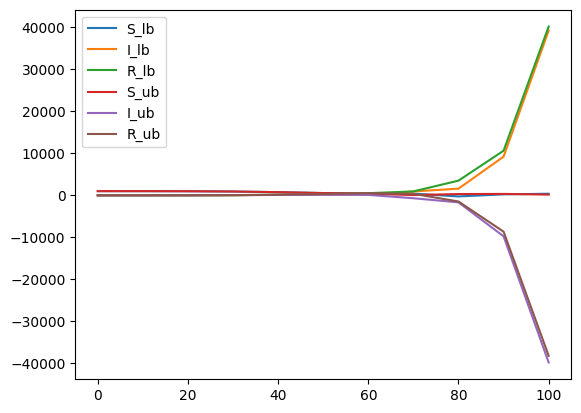

In [11]:
# 3) Analyze Bounded Base Model

bounded_request = get_request(requests[bounded_model_str])
setup_common(bounded_request, timepoints, debug=True, mode=MODE_ODEINT, synthesize=False,dreal_precision=1)
results = run(bounded_request, bounded_model_str, models)
report(results, bounded_model_str, bounded_model._state_var_names() + bounded_model._observable_names(), request_results, request_params)

In [12]:
df = results.dataframe(results.points())
all((df.I_lb + df.R_lb + df.S_lb) <= 1001.01)
all((df.I_ub + df.R_ub + df.S_ub) <= 1001.01)
# df.I_ub + df.R_ub + df.S_ub
df

,I_lb,I_ub,R_lb,R_ub,S_lb,S_ub,beta,beta_lb,beta_ub,gamma,gamma_lb,gamma_ub,id,index,label,timestep
0,1.000000,1.000000,0.000000,0.000000,1000.000000,1000.000000,None,0.00027,0.00027,None,0.14,0.14,0,0,true,10
1,1.264748,1.264748,0.286781,0.286781,999.448470,999.448470,None,0.00027,0.00027,None,0.14,0.14,0,1,true,10
2,1.529497,1.529497,0.573563,0.573563,998.896940,998.896940,None,0.00027,0.00027,None,0.14,0.14,0,2,true,10
3,1.794245,1.794245,0.860344,0.860344,998.345410,998.345410,None,0.00027,0.00027,None,0.14,0.14,0,3,true,10
4,2.058993,2.058993,1.147126,1.147126,997.793881,997.793881,None,0.00027,0.00027,None,0.14,0.14,0,4,true,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,27257.050685,-27800.816799,28394.859987,-26407.384014,321.748984,236.541157,None,0.00027,0.00027,None,0.14,0.14,0,96,true,10
97,30263.947960,-30806.772967,31354.678298,-29365.980091,336.407156,219.719644,None,0.00027,0.00027,None,0.14,0.14,0,97,true,10
98,33270.845235,-33812.729134,34314.496608,-32324.576168,351.065329,202.898131,None,0.00027,0.00027,None,0.14,0.14,0,98,true,10
99,36277.742510,-36818.685302,37274.314919,-35283.172245,365.723501,186.076618,None,0.00027,0.00027,None,0.14,0.14,0,99,true,10


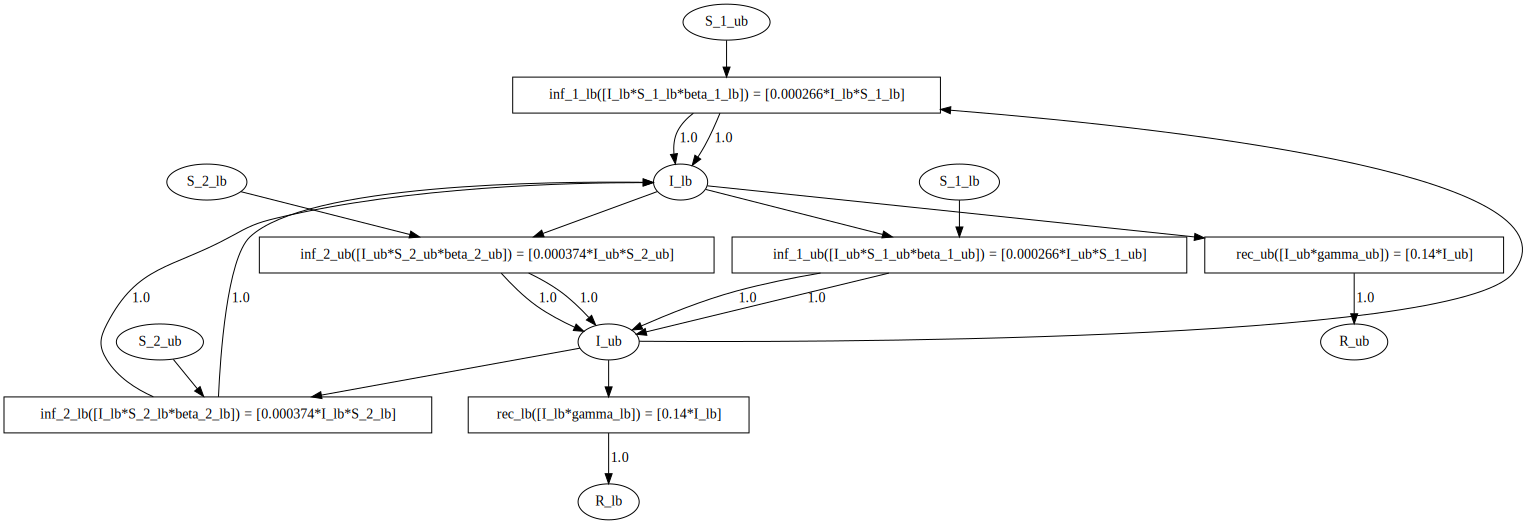

In [13]:
# Bound the stratified model

bounded_stratified_model: GeneratedPetriNetModel = formulate_bounds(stratified_model)
bounded_stratified_model_str = f"{model_str}_bounded_stratified"
bounded_stratified_model_path = os.path.join(EXAMPLE_DIR, bounded_stratified_model_str+".json")
models[bounded_stratified_model_str] = bounded_stratified_model_path
with open(bounded_stratified_model_path, "w") as f:
    f.write(bounded_stratified_model.petrinet.model_dump_json())
bounded_stratified_model.to_dot()

In [14]:
import sympy

def abstract(self, state_abstraction: Dict[str, str])-> GeneratedPetriNetModel:
    # Get existing state variables
    state_objs = {s.id: s for s in self._state_vars()}
    
    # Check that there is a state variable for each key in the state_abstraction
    assert all({k in state_objs for k in state_abstraction.keys()}), f"There are unknown states in the state_abstraction keys: {[k for k in state_abstraction.keys() if k not in state_objs]}"
    
    #Check that the state_abstraction maps the keys to a state variable that is not in the state_objs
    assert not any({v in state_objs for v in state_abstraction.values()}), f"There are unknown states in the state_abstraction values: {[v for v in state_abstraction.values() if v in state_objs]}"
    
    # Create states for values in state_abstraction
    new_state_objs = {v : State(id=v, name=v, description=None, grounding=None, units=None) for v in set(state_abstraction.values()) }
    
    new_states = [*[v for k, v in state_objs.items() if k not in state_abstraction.keys()], *new_state_objs.values()]
    
    # Replace states in the transitions
    subbed_state_ids = set(state_abstraction.keys())
    subbed_transitions = [ # transitions not involved in abstraction
        t for t in self.petrinet.model.transitions 
        if not any([s for s in t.input+t.output if s in subbed_state_ids])
        ] + [ # transitions with substitutions
             Transition(id=t.id, 
                        input=[(state_abstraction[i] if i in state_abstraction else i ) for i in t.input], 
                        output=[(state_abstraction[i] if i in state_abstraction else i ) for i in t.output], 
                        grounding=t.grounding, 
                        properties=t.properties)
             for t in self.petrinet.model.transitions 
            if any([s for s in t.input+t.output if s in subbed_state_ids])
        ]
    grouped_transitions = []
    for t in subbed_transitions:
        # Find group in grouped_transitions for t
        try:
            matching_group = next(iter([i for i, g in enumerate(grouped_transitions) if any([ t.input == gt.input and t.output==gt.output for gt in g])]))
            # print("append {t}")
            grouped_transitions[matching_group].append(t)
        except StopIteration:
            # If no group for t, then make a new group
            grouped_transitions.append([t])
    

    grouped_rates = [
            [
                next(Rate(target=r.target,
                        expression=str(to_sympy(r.expression, self._symbols())),
                        expression_mathml=None) 
                for r in self.petrinet.semantics.ode.rates if r.target == t.id) 
                for t in g
            ]  
            for g in grouped_transitions
        ]
    
    # Convert grouped transitions into a single transition
    consolidated_transitions=[]
    for g in grouped_transitions:
        if len(g) == 1:
            consolidated_transitions.append(g[0])
        else:
            sub_sequences = set(SequenceMatcher(None, g[0].id, g[1].id).get_matching_blocks())
            s_sub = list(sub_sequences)
            s_sub.sort(key=lambda x: min(x.a, x.b))
            sub = "".join([g[0].id[s.a:s.a+s.size] for s in s_sub if s.size > 0])
            for i, t in enumerate(g[2:]):
                sub_sequences = set(SequenceMatcher(None, sub, t.id).get_matching_blocks())
                s_sub = list(sub_sequences)
                s_sub.sort(key=lambda x: min(x.a, x.b))
                sub = "".join([g[0].id[s.a:s.a+s.size] for s in s_sub if s.size > 0])
            if sub.endswith("_"):
                sub = sub[:-1]
    
            consolidated_transitions.append(Transition(id=sub, input=g[0].input, output=g[0].output,grounding=g[0].grounding, properties=g[0].properties))
                
            
    ## Remove self transitions
    new_transitions = [t for t in consolidated_transitions if not (t.input == t.output and len(t.input) == 1)]
    
    
    def get_rate(self, target: str, rates: List[Rate], max_rate=False)-> Rate:
        # Identify which variables in the rate expressions are distinct 
        # Verify that by replacing the different variables that the expressions are identical
        expressions = [to_sympy(r.expression, self._symbols()) for r in rates]
        expression_symbols = [e.free_symbols for e in expressions]
        all_symbols = reduce(lambda x, y: x.union(y), expression_symbols[1:], set(expression_symbols[0]))
        common_symbols = reduce(lambda x, y: x.intersection(y), expression_symbols[1:], set(expression_symbols[0]))
        parameter_map = {}
        if all_symbols != common_symbols:
            # Need to find the min
            variable_value = {str(s): self._parameter_values()[str(s)] for s in all_symbols if s not in common_symbols}
            
            if max_rate:
                min_value = max(variable_value.values())    
                new_parameter_id = "max("+",".join([str(s) for s in all_symbols if s not in common_symbols])+")"
                
            else:
                min_value = min(variable_value.values())    
                new_parameter_id = "min("+",".join([str(s) for s in all_symbols if s not in common_symbols])+")"
            
            new_parameter_symbol = Symbol(new_parameter_id)
            new_expression = str(expressions[0].subs({old_symbol: new_parameter_symbol for old_symbol in all_symbols if old_symbol not in common_symbols}))
            parameter_map = {str(s): new_parameter_id for s in all_symbols if s not in common_symbols}
            # new_parameter = Parameter(id=new_parmeter_id, name=new_parameter_id, description="", value=min_value )
        else:
            new_expression = str(expressions[0])
       
        return (Rate(target=target,
                    expression=new_expression),
                parameter_map
        )
        
    def aggregate_rates(self, rates, abstraction):
        expressions = [to_sympy(r.expression, self._symbols()) for r in rates]
        starting_expression = reduce(lambda x, y: x+y, expressions)
        
        # invert the abstraction
        i_abstraction = {k: [v for v in abstraction.keys() if abstraction[v] == k] for k in abstraction.values()}
        
        
        # abstraction implies that abstract variable is sum of variables mapped to it
        abstraction_substitution = {Symbol(i_abstraction[k][0]): sympy.sympify(f"{k}-{'-'.join(i_abstraction[k][1:])}") for k in i_abstraction.keys()}
        # abstraction_substitution = {Symbol(k): [Symbol(v) for v in v_list] for k, v_list in abstraction_substitution.items()}
        
        expression_symbols = [e.free_symbols for e in expressions]
        all_symbols = reduce(lambda x, y: x.union(y), expression_symbols[1:], set(expression_symbols[0]))
        common_symbols = reduce(lambda x, y: x.intersection(y), expression_symbols[1:], set(expression_symbols[0]))
        unique_symbols = [s for s in all_symbols if s not in common_symbols and str(s) not in abstraction]
        
        # FIXME need to remove double counting of parameters p_I_I and beta_I_I
        parameter_minimization = {str(s) : f"agg_{'_'.join([str(us) for us in unique_symbols])}" for s in unique_symbols}
        
        # substitute abstraction into starting expression
        abstract_expression = sympy.expand(starting_expression.subs({**abstraction_substitution, **parameter_minimization}))
            
        
        # abstract_expression1 = sympy.expand(sympy.expand(starting_expression.subs(abstraction_substitution )).subs(parameter_minimization))
        return {
                "rate" : str(abstract_expression), 
                "parameters" : parameter_minimization
            }
    
    
    aggregated_rates_and_parameters = [
        aggregate_rates(self, g, state_abstraction) #reduce(lambda x, y: x+y, [to_sympy(r.expression, self._symbols()) for r in g]) #"+".join([f"({r.expression})" for r in g]) 
        for i, g in enumerate(grouped_rates) if i < len(new_transitions)
    ]
    
    # New Rates
    new_rates = [ 
            Rate(
                target= new_transitions[i].id,
                expression=aggregated_rates_and_parameters[i]["rate"]
            )
            for i, g in enumerate(grouped_rates) if i < len(new_transitions)
        ]

    new_parameters = [
        p
        for p in self.petrinet.semantics.ode.parameters
        if not any([p.id in rp['parameters'] for rp in aggregated_rates_and_parameters]) and any([p.id in r.expression for r in new_rates])
    ] + [
        Parameter(id=p, name=p, description=p, v=0.0, grounding=None, distribution=None, units=None) 
        for arp in aggregated_rates_and_parameters
        for p in set(arp['parameters'].values())
    ]
    
    new_initials = [
        # Initial.model_copy(st)
        next(i for i in self.petrinet.semantics.ode.initials if i.target == st.id)  
        for st in new_states
        if st.id not in new_state_objs
    ] + [
        Initial(target=s_id,expression=str(reduce(lambda x, y: x+y, [to_sympy(o_s.expression, self._symbols()) for o_s in [next(i for i in self.petrinet.semantics.ode.initials if i.target == o_s_id)  for o_s_id in [k for k, v in state_abstraction.items() if v == s_id]]], 0.0)))
        for s_id, st in new_state_objs.items()
        
        if s_id in new_state_objs
    ]
    
    new_metadata= self.petrinet.metadata.copy()
    new_metadata["abstraction"] = {
        # Need to know which parameter to replace by the min or max value, as well as the min and max value
        # parameters -> transition_id -> parameter_id -> [lb,ub]
        "parameters" : { 
            new_rates[i].target : {
                    p: {
                        "lb": min([next(p2 for p2 in self.petrinet.semantics.ode.parameters if p2.id==p1).value 
                                   for p1, v in aggregated_rates_and_parameters[4]['parameters'].items() 
                                   if v == p]), 
                        "ub": max([next(p2 for p2 in self.petrinet.semantics.ode.parameters if p2.id==p1).value 
                                   for p1, v in aggregated_rates_and_parameters[4]['parameters'].items() 
                                   if v == p])} 
                    for p in set(aggregated_rates_and_parameters[i]['parameters'].values())
                }  
            for i, arp in enumerate(aggregated_rates_and_parameters)
            if len(arp['parameters'])>0}
        }


    new_model = GeneratedPetriNetModel(
                    petrinet=Model(
                        header=self.petrinet.header,
                        properties=self.petrinet.properties,
                        model=Model1(
                          states=new_states, 
                          transitions=new_transitions #[*new_transitions, *other_transitions.values(), *self_strata_transitions]
                          ),
                        semantics=Semantics(
                          ode=OdeSemantics(
                              rates=new_rates, #[*new_rates, *other_rates.values(), *self_strata_rates], 
                              initials=new_initials, #new_initials, 
                              parameters=new_parameters, 
                              observables=None, #new_observables,
                              time=self.petrinet.semantics.ode.time), 
                          typing=self.petrinet.semantics.typing, 
                          span=self.petrinet.semantics.span),
                      metadata=new_metadata
                      ))
    return new_model

abstract_stratified_model: GeneratedPetriNetModel = abstract(stratified_model, {"I_u": "I", "I_v": "I"}) #formulate_bounds(abstract(stratified_model, {"I_u": "I", "I_v": "I"}))
# mb.to_dot()

# stratified_model = stratify(base_model, "I", ["u", "v"], strata_parameter="beta", strata_transitions=["t1"], self_strata_transition=True)
abstract_stratified_model_str = f"{model_str}_abstract_stratified"

abstract_stratified_model_path = os.path.join(EXAMPLE_DIR, abstract_stratified_model_str+".json")
models[abstract_stratified_model_str] = abstract_stratified_model_path
with open(abstract_stratified_model_path, "w") as f:
    f.write(abstract_stratified_model.petrinet.model_dump_json())


abstract_stratified_model.to_dot()

AssertionError: There are unknown states in the state_abstraction keys: ['I_u', 'I_v']

In [ ]:
# Bound the abstract stratified model
abstract_stratified_bounded_model: GeneratedPetriNetModel = formulate_bounds(abstract_stratified_model)
abstract_stratified_bounded_model_str = f"{model_str}_abstract_stratified_bounded"
abstract_stratified_bounded_model_path = os.path.join(EXAMPLE_DIR, abstract_stratified_bounded_model_str+".json")
models[abstract_stratified_bounded_model_str] = abstract_stratified_bounded_model_path
with open(abstract_stratified_bounded_model_path, "w") as f:
    f.write(abstract_stratified_bounded_model.petrinet.model_dump_json())
abstract_stratified_bounded_model.to_dot()

In [ ]:
# 4) Analyze Abstract Stratified Bounded Base Model

abstract_stratified_bounded_request = get_request(models[abstract_stratified_bounded_model_str])
setup_common(abstract_stratified_bounded_request, timepoints, debug=True, mode=MODE_SMT, synthesize=False,dreal_precision=0.1)
results = run(abstract_stratified_bounded_request, abstract_stratified_bounded_model_str, models)
report(results, abstract_stratified_bounded_model_str, abstract_stratified_bounded_model._state_var_names() + abstract_stratified_bounded_model._observable_names(), request_results, request_params)

In [ ]:
stratify(base_model, "I", ["u", "v"], strata_parameters="beta", strata_transitions=["t3"], self_strata_transition=True).to_dot()
